In [283]:
import numpy as np
import matplotlib.pyplot as plt 

import importlib

import components as comp
importlib.reload(comp);

import utils
importlib.reload(utils);

In [284]:
### Parameters
computational_states    = 3
resonator_states        = 10

# System
system = utils.System(dimensions = (computational_states, resonator_states))

# Readout duration
duration = (0, 50)

# Define the components, which are defined in components.py
# The superconducting qubit
transmon = comp.Transmon(
    n_cutoff        = 11,
    e               = 1.519e6,              # GHz / V
    EJ              = 34,                   # GHz hbar
    EJ_EC_ratio     = 128,                  # Gives EC = EJ / ratio
    # gamma           = 2.5                 # EJ2 / EJ1    
)

# Resonator for readout
resonator = comp.Resonator(
    omega           = 6.02,                 # GHz
    n_cutoff        = resonator_states      # States of harmonic oscillator
    
)

# Readout pulse
readout_pulse = comp.ResonatorProbePulse(
    omega       = 6.02,
    duration    = (20, 30),
    rise_time   = 2,
    fall_time   = 2,
    amplitude   = 5 / 6.02 ** 2
)


## Defining Hamiltonians
We can now define the hamiltonians of the system:

In [285]:
# Find subspace of Transmon
Es, Psis = transmon.eigen_basis(computational_states)   # Get states and energies for transmon
H0_transmon = np.diag(Es - Es[0])                       # Set E0 = 0


# H0 of the resonator is simply found by:
H0_resonator    = resonator.Hamiltonian().todense()


# We need to define mathematical tools to combine the system
transmon_identity   = np.identity(n = computational_states)
resonator_identity  = np.identity(n = resonator_states)


# Combine the Hamiltonians by tensor product 
H0_transmon_big  = np.kron(resonator_identity,  H0_transmon)
H0_resonator_big = np.kron(H0_resonator,        transmon_identity)

# Sum to get full H0 in 3 x 20 space
H0 = H0_transmon_big + H0_resonator_big


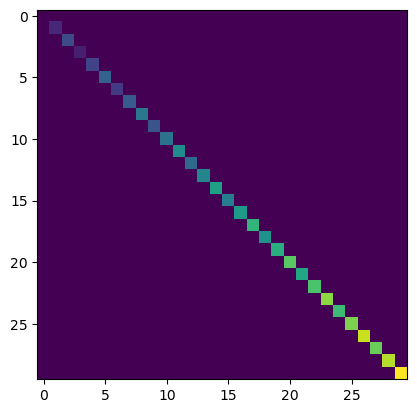

In [286]:
plt.imshow(H0)

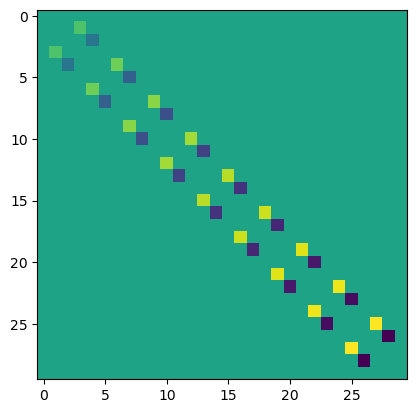

In [287]:
# Transmon interaction
H_overlap_n = np.conjugate(Psis).T @ transmon.n_matrix() @ Psis

#### NEED MORE THEORY TO DEFINE THIS INTERACTION TERM #### 
# Now we just assume g_k = 1. Probably we take the overlap between them.
H_int_resonator = (resonator.a_dagger() + resonator.a()).todense()

# Direct product to get it in 3 x 20 hilbert space
H_int = np.kron(np.triu(H_int_resonator), np.tril(H_overlap_n)) + np.kron(np.tril(H_int_resonator), np.triu(H_overlap_n))


plt.imshow(H_int)

## Interaction Eigenvalues 

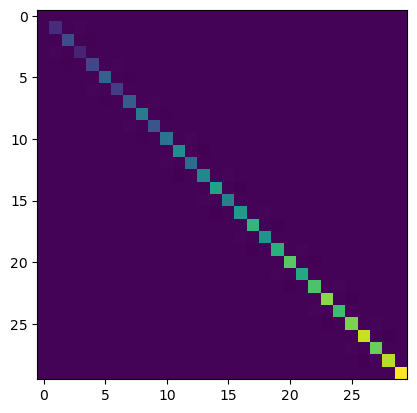

In [288]:
interaction_strength = 0.130 # GHz 

H_with_interaction = H0 + interaction_strength *  H_int
plt.imshow(H_with_interaction)

## Readout Drive

In [289]:
from scipy.linalg import expm
@jit()
def U(t):
    return np.eye(H0.shape[0]) * np.exp(1j * 6.02 * t)
    # return np.diag(np.exp(1j * np.diag(H0) * t))

In [290]:
plt.show()

In [291]:
from numba import jit

In [292]:
pulse_on_resonator = readout_pulse.output()

# Define the time dependent Hamiltonian to drive the resonator
@jit()
def H_resonator_drive(t):
    total_pulse = pulse_on_resonator[0](t) + pulse_on_resonator[1](t) 
    H_reso      = 2j *  total_pulse * (resonator.a_dagger() - resonator.a())

    H_reso_hilbert_space = np.kron(H_reso.todense(), transmon_identity)

    return H_reso_hilbert_space


In [293]:
@jit()
def total_hamiltonian(t):
    return (H_with_interaction + H_resonator_drive(t)) 

dimensions = (resonator_states * computational_states, resonator_states * computational_states)

# Define the master equation
@jit()
def master_equation(t, y):
    U_matrix = U(t)
    U_matrix_dagger = U_matrix.conj().T

    density_matrix = U_matrix @ y.reshape(dimensions) @ U_matrix_dagger

    # Calculate the time dependent hamiltonian
    H_t = U_matrix @ total_hamiltonian(t) @ U_matrix_dagger
    
    # Calculate the time derivative of the density matrix
    d_rho = -1j * (H_t @ density_matrix - density_matrix @ H_t.conj().T)
    
    d_rho = U_matrix_dagger @ d_rho @ U_matrix

    return d_rho.flatten()

# Define the first excited state of the resonator
resonator_e = np.zeros(resonator_states, dtype = np.complex128)
resonator_e[0] = 1

# Define ground state of transmon
transmon_g = np.array((1, 0, 0), dtype = np.complex128)

# Define initial density matrix
initial_state = np.kron(resonator_e, transmon_g)
initial_density_matrix = np.outer(initial_state, initial_state.conj())

# Solve the master equation
from scipy.integrate import solve_ivp
results = solve_ivp(master_equation, duration, initial_density_matrix.flatten())


/tmp/ipykernel_9590/1844132581.py:8: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "master_equation" failed type inference due to: Invalid use of type(CPUDispatcher(<function total_hamiltonian at 0x7f713560d700>)) with parameters (float64)

During: resolving callee type: type(CPUDispatcher(<function total_hamiltonian at 0x7f713560d700>))
During: typing of call at /tmp/ipykernel_9590/1844132581.py (16)


File "../../../../../../../../../tmp/ipykernel_9590/1844132581.py", line 16:
<source missing, REPL/exec in use?>

  @jit()
/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "master_equation" was compiled in object mode without forceobj=True.

File "../../../../../../../../../tmp/ipykernel_9590/1844132581.py", line 8:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-pac

In [296]:

density_matrices = [results.y[:, i].reshape(dimensions) for i in range(len(results.t))]
density_matrices = np.array(density_matrices)

resonator_density_matrices = [system.partial_trace(density_matrices[i], 0) for i in range(len(results.t))]
resonator_density_matrices = np.array(resonator_density_matrices)


avg_photon_count = np.trace(np.expand_dims(resonator.n_matrix().todense(), 0) @ resonator_density_matrices, axis1 = 1, axis2 = 2)

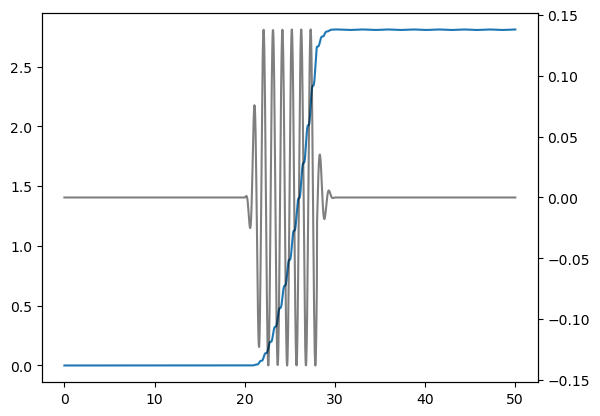

In [297]:
fig, ax = plt.subplots()
ax.plot(results.t, avg_photon_count)
# plt.plot(results.t, np.imag(S11))

ax1 = ax.twinx()
ax1.plot(results.t, pulse_on_resonator[0](results.t) + pulse_on_resonator[1](results.t) , color = 'black', alpha = 0.5)
# ax1.set_ylim(-1.1, 5)